#Ecommerce Text Classification (TF-IDF + Word2Vec)



#Learnings

Throughout this project, we undertook a comprehensive process to effectively categorize e-commerce products into four main categories: Electronics, Household, Books, and Clothing & Accessories. Here's an overview of the key learning points derived from our project:

**Exploratory Data Analysis (EDA)**: We initiated the project by conducting EDA to understand the characteristics of product descriptions across different categories. Metrics such as character count, word count, and average word length provided valuable insights into the nature of the data, enabling us to make informed decisions during subsequent preprocessing steps.

**Text Normalization Techniques**: We recognized the importance of consistent and well-preprocessed text data for optimal model performance. By implementing various text normalization techniques, we ensured that the data was uniform and ready for further analysis. Techniques such as lowercasing, handling contractions, and other normalization steps contributed to enhancing the quality of our dataset.

**TF-IDF Vectorization**: Leveraging TF-IDF vectorization, we transformed the preprocessed product descriptions into numerical vectors, facilitating the application of machine learning algorithms. This step enabled us to quantify the significance of terms within the descriptions, paving the way for effective categorization.

**Baseline Model Establishment**: We established a baseline performance by evaluating several classifiers on the TF-IDF transformed data. Subsequently, we fine-tuned the support vector machine classifier with a linear kernel through hyperparameter tuning, aiming to improve the model's predictive accuracy.

**Alternative Approach with Word2Vec**: Exploring an alternative approach, we applied specific text normalization methods directly to the raw data and utilized Google's pre-trained Word2Vec model to obtain embeddings for the partially normalized descriptions. This approach allowed us to capture semantic relationships within the text, enhancing the representation of the product descriptions.

**Model Selection and Optimization**: We compared the baseline performance of various classifiers on the Word2Vec embeddings and optimized the hyperparameters of the XGBoost classifier, aiming to maximize the model's predictive performance.

**Evaluation and Testing**: Finally, we evaluated the trained models on a separate test dataset to assess their performance. The model with the highest validation accuracy was selected for predicting the labels of the test observations, achieving a commendable test accuracy of 94.89%.

By following these systematic steps and leveraging various techniques, we successfully developed a robust classification model for e-commerce product categorization, demonstrating the effectiveness of machine learning in addressing real-world challenges in the domain of e-commerce.

Importing libraries

In [ ]:
# File system manangement
import time, psutil, os

# Data manipulation
import numpy as np
import pandas as pd

# Plotting and visualization
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
sns.set_theme()
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

# NLP
import string, re, nltk
from string import punctuation
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
!pip install num2words
from num2words import num2words
!pip install pyspellchecker
from spellchecker import SpellChecker
from nltk.stem.porter import PorterStemmer
import spacy
from nltk.stem import WordNetLemmatizer

# TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

# Scipy
import scipy
from scipy import sparse
from scipy.sparse import csr_matrix

# Train-test split and cross validation
from sklearn.model_selection import train_test_split, ParameterGrid

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import RidgeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier

# Model evaluation
from sklearn import metrics
from sklearn.metrics import accuracy_score

# Others
import json
import gensim
from sklearn.decomposition import TruncatedSVD

#**Introduction**


*   E-commerce Product Categorization
*   Text Classification

*   Data
*   Project Objective





**E-commerce Product Categorization**

E-commerce, or electronic commerce, entails the buying and selling of products or services over the Internet or online services. It relies heavily on web-based platforms for various stages of a transaction, although other technologies like email may also be involved. Common e-commerce activities include purchasing items such as books from platforms like Amazon or downloading music through digital distribution channels like the iTunes Store. E-commerce primarily encompasses online retail, electronic markets, and online auctions, and it is closely linked with electronic business.

The objective of product categorization, a form of economic taxonomy, involves organizing products into distinct categories. This process serves two main purposes: establishing and expanding the structure of product catalogs, and accurately tagging products with appropriate categories and attributes. While machine learning may not be extensively utilized for creating catalog structures, it holds promise for automating the laborious task of categorizing products based on their descriptions. This categorization effort aims to streamline user experiences and optimize search engine results, enabling visitors to easily locate desired products through catalog navigation or website searches.


**Text Classification**

Text classification is a commonly employed task in natural language processing across various business scenarios.

The primary objective is to assign a suitable category from a predefined set to a given statement or document.

The categories are typically determined by the dataset being used.
Text classification finds application in diverse fields such as emotion classification, news categorization, spam email detection, and auto-tagging of customer queries.

In our current problem context, the statements correspond to product descriptions, while the categories include Electronics, Household, Books, and Clothing & Accessories.

**Data**

Original source: https://doi.org/10.5281/zenodo.3355823

The dataset has been scraped from Indian e-commerce platform(s). It contains e-commerce text data for four categories: Electronics, Household, Books and Clothing & Accessories. Roughly speaking, these four categories cover  
80
%
  of any e-commerce website, by and large. The dataset is in .csv format and consists of two columns. The first column gives the target class name and the second column gives the datapoint, which is the description of the product from the e-commerce website. We insert column names and swap the columns, to put the target column at the right.

In [ ]:
data = pd.read_csv('/content/ecommerceDataset.csv')
data = data[['Description','label']]
print(pd.Series({"Memory usage": "{:.2f} MB".format(data.memory_usage().sum()/(1024*1024)),
                 "Dataset shape": "{}".format(data.shape)}).to_string())
data

Memory usage        0.77 MB
Dataset shape    (50425, 2)


,Description,label
0,Paper Plane Design Framed Wall Hanging Motivat...,Household
1,"SAF 'Floral' Framed Painting (Wood, 30 inch x ...",Household
2,SAF 'UV Textured Modern Art Print Framed' Pain...,Household
3,"SAF Flower Print Framed Painting (Synthetic, 1...",Household
4,Incredible Gifts India Wooden Happy Birthday U...,Household
...,...,...
50420,Strontium MicroSD Class 10 8GB Memory Card (Bl...,Electronics
50421,CrossBeats Wave Waterproof Bluetooth Wireless ...,Electronics
50422,Karbonn Titanium Wind W4 (White) Karbonn Titan...,Electronics
50423,"Samsung Guru FM Plus (SM-B110E/D, Black) Colou...",Electronics


In [ ]:
# Example description
data['Description'].iloc[0]

'Paper Plane Design Framed Wall Hanging Motivational Office Decor Art Prints (8.7 X 8.7 inch) - Set of 4 Painting made up in synthetic frame with uv textured print which gives multi effects and attracts towards it. This is an special series of paintings which makes your wall very beautiful and gives a royal touch. This painting is ready to hang, you would be proud to possess this unique painting that is a niche apart. We use only the most modern and efficient printing technology on our prints, with only the and inks and precision epson, roland and hp printers. This innovative hd printing technique results in durable and spectacular looking prints of the highest that last a lifetime. We print solely with top-notch 100% inks, to achieve brilliant and true colours. Due to their high level of uv resistance, our prints retain their beautiful colours for many years. Add colour and style to your living space with this digitally printed painting. Some are for pleasure and some for eternal blis

In [ ]:
# Missing values and duplicate observations
print(pd.Series({"Number of observations with missing values": len(data) - len(data.dropna()),
                 "Number of duplicate observations": data.duplicated().sum()}).to_string())

Number of observations with missing values        5
Number of duplicate observations              22624


In [ ]:
data.dropna(inplace = True) # Dropping observations with missing values
data.drop_duplicates(inplace = True) # Dropping duplicate observations
data.reset_index(drop = True, inplace = True) # Resetting index

The labels are manually encoded with the following scheme:

Electronics  ↦ 0

Household  ↦   1

Books  ↦ 2

Clothing & Accessories  ↦ 3

In [ ]:
# Manual encoding of labels
label_dict = {'Electronics': 0, 'Household': 1, 'Books': 2, 'Clothing & Accessories': 3}
data.replace({'label': label_dict}, inplace = True)

print(pd.Series({"Memory usage": "{:.2f} MB".format(data.memory_usage().sum()/(1024*1024)),
                 "Dataset shape": "{}".format(data.shape)}).to_string())
data

Memory usage        0.42 MB
Dataset shape    (27799, 2)


,Description,label
0,Paper Plane Design Framed Wall Hanging Motivat...,1
1,"SAF 'Floral' Framed Painting (Wood, 30 inch x ...",1
2,SAF 'UV Textured Modern Art Print Framed' Pain...,1
3,"SAF Flower Print Framed Painting (Synthetic, 1...",1
4,Incredible Gifts India Wooden Happy Birthday U...,1
...,...,...
27794,Micromax Bharat 5 Plus Zero impact on visual d...,0
27795,Microsoft Lumia 550 8GB 4G Black Microsoft lum...,0
27796,"Microsoft Lumia 535 (Black, 8GB) Colour:Black ...",0
27797,Karbonn Titanium Wind W4 (White) Karbonn Titan...,0


**Project Objective**

The objective of the project is to classify a product into the four categories Electronics, Household, Books and Clothing & Accessories, based on its description available in the e-commerce platform.

#**Exploratory Data Analysis**

We split the dataset based on the target classes, in order to see how different textual attributes vary across classes

In [ ]:
# Splitting the dataset by label
data_e = data[data['label'] == 0] # Electronics
data_h = data[data['label'] == 1] # Household
data_b = data[data['label'] == 2] # Books
data_c = data[data['label'] == 3] # Clothing & Accessories

**Class Frequencies**

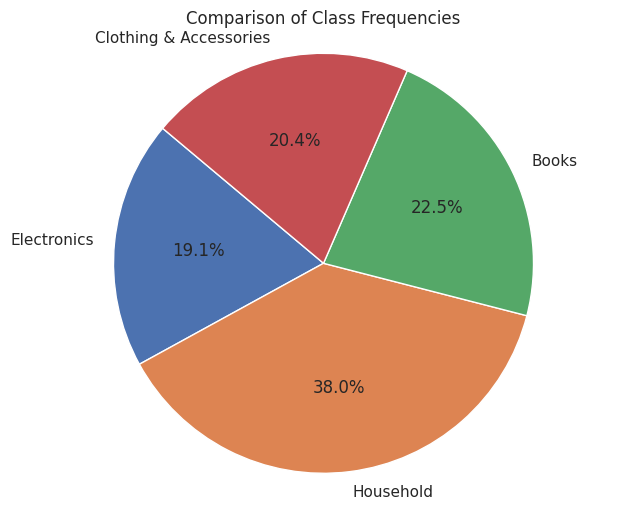

In [ ]:
import matplotlib.pyplot as plt

# Data
values = [len(data_e), len(data_h), len(data_b), len(data_c)]
labels = ['Electronics', 'Household', 'Books', 'Clothing & Accessories']

# Plotting
plt.figure(figsize=(8, 6))
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Comparison of Class Frequencies')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


**Number of Characters**

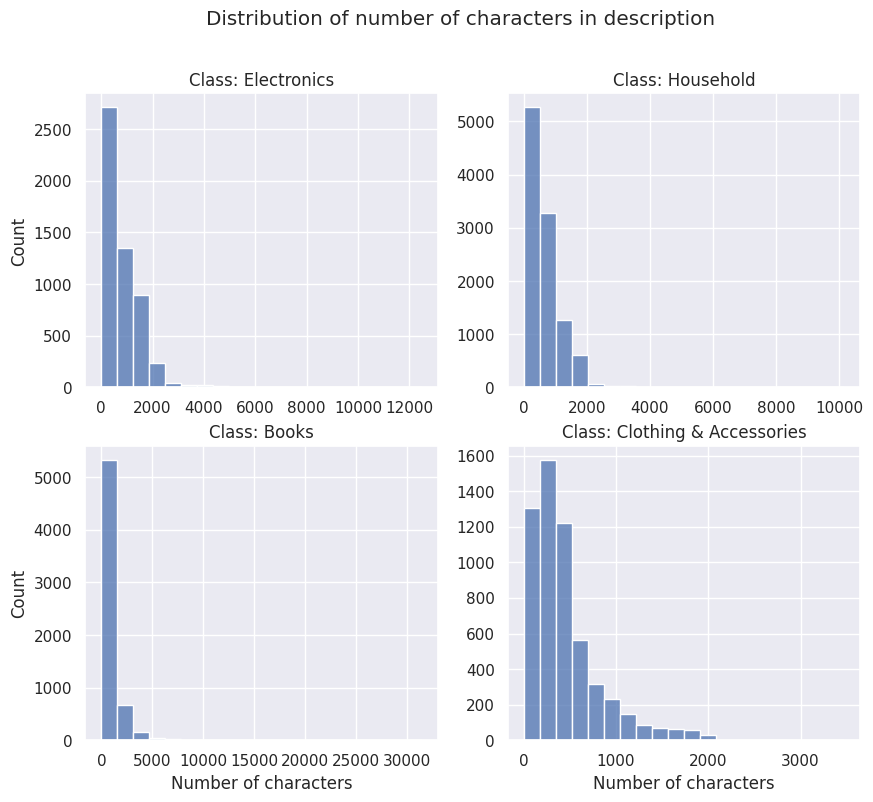

In [ ]:
# Distribution of number of characters in description
data_e_char = data_e['Description'].str.len()
data_h_char = data_h['Description'].str.len()
data_b_char = data_b['Description'].str.len()
data_c_char = data_c['Description'].str.len()

fig, ax = plt.subplots(2, 2, figsize = (10, 8.4), sharey = False)
sns.histplot(x = data_e_char, bins = 20, ax = ax[0, 0]).set_title('Class: Electronics')
sns.histplot(x = data_h_char, bins = 20, ax = ax[0, 1]).set_title('Class: Household')
sns.histplot(x = data_b_char, bins = 20, ax = ax[1, 0]).set_title('Class: Books')
sns.histplot(x = data_c_char, bins = 20, ax = ax[1, 1]).set_title('Class: Clothing & Accessories')

fig.suptitle("Distribution of number of characters in description")
for i in range(4):
    ax[i // 2, i % 2].set_xlabel(" ") if i // 2 == 0 else ax[i // 2, i % 2].set_xlabel("Number of characters")
    if i % 2 != 0: ax[i // 2, i % 2].set_ylabel(" ")

**Number of Words**

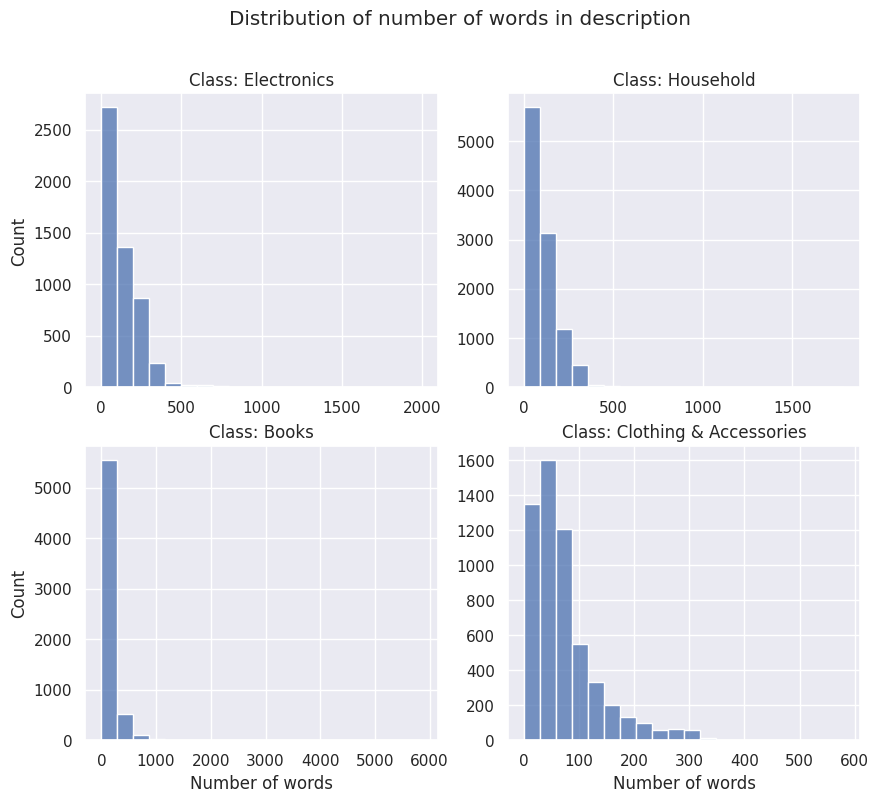

In [ ]:
# Distribution of number of words in description
data_e_word = data_e['Description'].str.split().map(lambda x: len(x))
data_h_word = data_h['Description'].str.split().map(lambda x: len(x))
data_b_word = data_b['Description'].str.split().map(lambda x: len(x))
data_c_word = data_c['Description'].str.split().map(lambda x: len(x))

fig, ax = plt.subplots(2, 2, figsize = (10, 8.4), sharey = False)
sns.histplot(x = data_e_word, bins = 20, ax = ax[0, 0]).set_title('Class: Electronics')
sns.histplot(x = data_h_word, bins = 20, ax = ax[0, 1]).set_title('Class: Household')
sns.histplot(x = data_b_word, bins = 20, ax = ax[1, 0]).set_title('Class: Books')
sns.histplot(x = data_c_word, bins = 20, ax = ax[1, 1]).set_title('Class: Clothing & Accessories')

fig.suptitle("Distribution of number of words in description")
for i in range(4):
    ax[i // 2, i % 2].set_xlabel(" ") if i // 2 == 0 else ax[i // 2, i % 2].set_xlabel("Number of words")
    if i % 2 != 0: ax[i // 2, i % 2].set_ylabel(" ")

**Average Word-length**

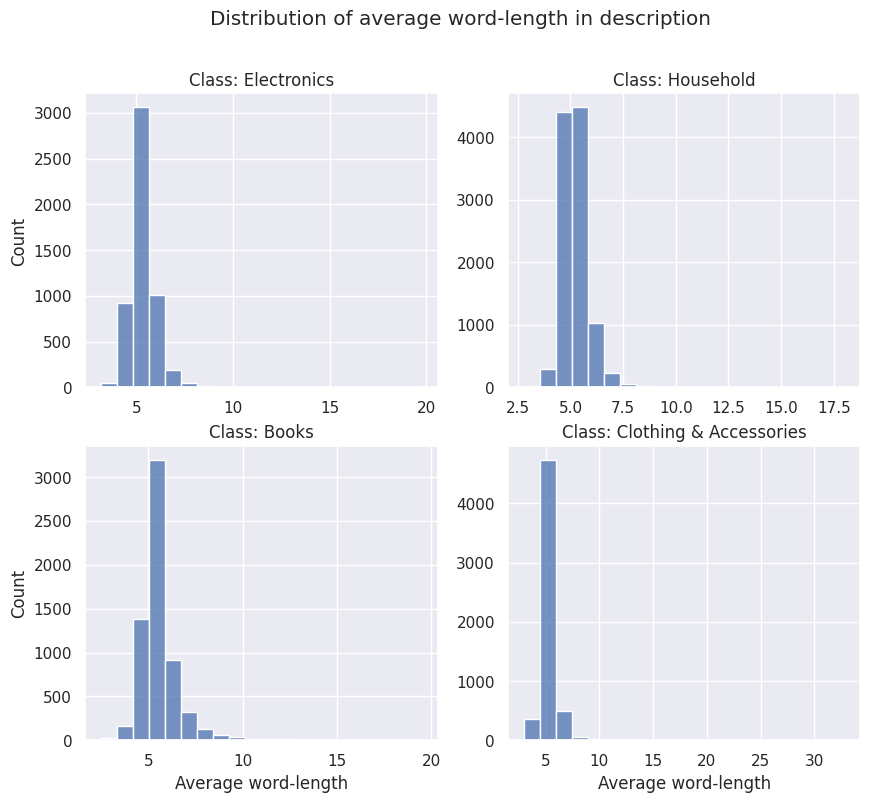

In [ ]:
# Distribution of average word-length in description
data_e_avg = data_e['Description'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x))
data_h_avg = data_h['Description'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x))
data_b_avg = data_b['Description'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x))
data_c_avg = data_c['Description'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x))

fig, ax = plt.subplots(2, 2, figsize = (10, 8.4), sharey = False)
sns.histplot(x = data_e_avg, bins = 20, ax = ax[0, 0]).set_title('Class: Electronics')
sns.histplot(x = data_h_avg, bins = 20, ax = ax[0, 1]).set_title('Class: Household')
sns.histplot(x = data_b_avg, bins = 20, ax = ax[1, 0]).set_title('Class: Books')
sns.histplot(x = data_c_avg, bins = 20, ax = ax[1, 1]).set_title('Class: Clothing & Accessories')

fig.suptitle("Distribution of average word-length in description")
for i in range(4):
    ax[i // 2, i % 2].set_xlabel(" ") if i // 2 == 0 else ax[i // 2, i % 2].set_xlabel("Average word-length")
    if i % 2 != 0: ax[i // 2, i % 2].set_ylabel(" ")

**Train-Validation-Test Split**

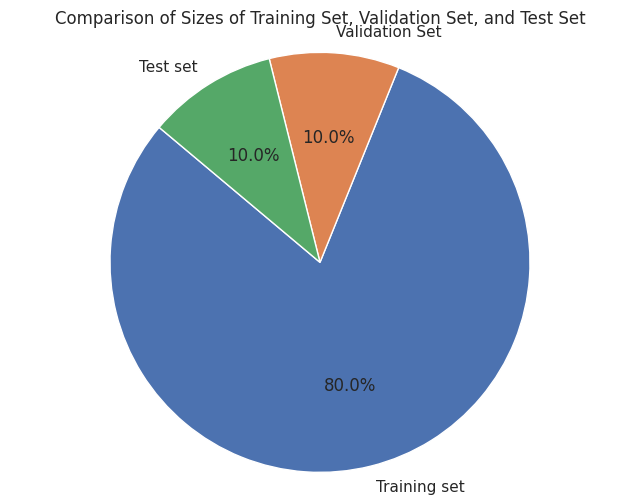

In [ ]:
# Feature-target split
X, y = data.drop('label', axis = 1), data['label']

# Train-test split (from complete data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 40)
data_train = pd.concat([X_train, y_train], axis = 1)

# Validation-test split (from test data)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5, random_state = 40)
data_val, data_test = pd.concat([X_val, y_val], axis = 1), pd.concat([X_test, y_test], axis = 1)

import matplotlib.pyplot as plt
# Data
sizes = [len(data_train), len(data_val), len(data_test)]
labels = ['Training set', 'Validation Set', 'Test set']
# Plotting
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Comparison of Sizes of Training Set, Validation Set, and Test Set')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


#**Text Normalization**

In natural language processing, text normalization is the process of transforming text into a single canonical form. We consider a number of text normalization processes. At the end of the section, we combine selected processes into one single function and apply it on the product descriptions.

In [ ]:
# RegexpTokenizer
regexp = RegexpTokenizer("[\w']+")

**Convertion to Lowercase**

We convert all alphabetical characters of the tweets to lowercase so that the models do not differentiate identical words due to case-sensitivity. For example, without the normalization, Sun and sun would have been treated as two different words, which is not useful in the present context.

In [ ]:
# Converting to lowercase
def convert_to_lowercase(text):
    return text.lower()

text = "This is a FUNCTION that CoNvErTs a Text to lowercase"
print("Input: {}".format(text))
print("Output: {}".format(convert_to_lowercase(text)))

Input: This is a FUNCTION that CoNvErTs a Text to lowercase
Output: this is a function that converts a text to lowercase


**Removal of Whitespaces**

We remove the unnecessary empty spaces from the description of the observations.

In [ ]:
# Removing whitespaces
def remove_whitespace(text):
    return text.strip()

text = " \t This is a string \t "
print("Input: {}".format(text))
print("Output: {}".format(remove_whitespace(text)))

Input:  	 This is a string 	 
Output: This is a string


**Removal of Punctuations**

Mostly the punctuations do not play any role in predicting whether a particular tweet indicate disaster or not. Thus we prevent them from contaminating the classification procedures by removing them from the tweets. However, we keep **apostrophe** since most of the contractions contain this punctuation and will be automatically taken care of once we convert the contractions.

In [ ]:
# Removing punctuations
import string
def remove_punctuation(text):
    punct_str = string.punctuation
    punct_str = punct_str.replace("'", "") # discarding apostrophe from the string to keep the contractions intact
    return text.translate(str.maketrans("", "", punct_str))

text = "Here's [an] example? {of} &a string. with.? punctuations!!!!"
print("Input: {}".format(text))
print("Output: {}".format(remove_punctuation(text)))

Input: Here's [an] example? {of} &a string. with.? punctuations!!!!
Output: Here's an example of a string with punctuations


**Removal of Unicode Characters**

The training tweets are typically sprinkled with emojis, URLs, punctuation and other symbols that do not contribute meaningfully to our analysis, but instead create noise in the learning procedure. Some of these symbols are unique, while the rest usually translate into unicode strings. We remove these irrelevant characters from the data using the regular expression module.

In [ ]:
# Removing HTML tags
def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'', text)

text = '<a href = "https://datasets/ecommerce-text-classification"> Ecommerce Text Classification </a>'
print("Input: {}".format(text))
print("Output: {}".format(remove_html(text)))

Input: <a href = "https://datasets/ecommerce-text-classification"> Ecommerce Text Classification </a>
Output:  Ecommerce Text Classification 


In [ ]:
# Removing emojis
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags = re.UNICODE)
    return emoji_pattern.sub(r'', text)

text = "This innovative hd printing technique results in durable and spectacular looking prints 😊"
print("Input: {}".format(text))
print("Output: {}".format(remove_emoji(text)))

Input: This innovative hd printing technique results in durable and spectacular looking prints 😊
Output: This innovative hd printing technique results in durable and spectacular looking prints 


In [ ]:
# Removing other unicode characters
def remove_http(text):
    http = "https?://\S+|www\.\S+" # matching strings beginning with http (but not just "http")
    pattern = r"({})".format(http) # creating pattern
    return re.sub(pattern, "", text)

text = "It's a function that removes links starting with http: or https such as https://en.wikipedia.org/wiki/Unicode_symbols"
print("Input: {}".format(text))
print("Output: {}".format(remove_http(text)))

Input: It's a function that removes links starting with http: or https such as https://en.wikipedia.org/wiki/Unicode_symbols
Output: It's a function that removes links starting with http: or https such as 


**Substitution of Acronyms**

Acronyms are shortened forms of phrases, generally found in informal writings. For instance, for your information is written as fyi and by the way is written as btw. These time and effort-saving acronyms have received almost universal acceptance in recent times. For the sake of proper modeling, we convert the acronyms, appearing in the tweets, back to their respective original forms.

In [ ]:
# Dictionary of acronyms
acronyms_url = 'https://raw.githubusercontent.com/sugatagh/E-commerce-Text-Classification/main/JSON/english_acronyms.json'
acronyms_dict = pd.read_json(acronyms_url, typ = 'series')

print("Example: Original form of the acronym 'fyi' is '{}'".format(acronyms_dict['fyi']))

Example: Original form of the acronym 'fyi' is 'for your information'


In [ ]:
# Dataframe of acronyms
pd.DataFrame(acronyms_dict.items(), columns = ['acronym', 'original']).head()

,acronym,original
0,aka,also known as
1,asap,as soon as possible
2,brb,be right back
3,btw,by the way
4,dob,date of birth


In [ ]:
# List of acronyms
acronyms_list = list(acronyms_dict.keys())

In [ ]:
# Function to convert contractions in a text
def convert_acronyms(text):
    words = []
    for word in regexp.tokenize(text):
        if word in acronyms_list:
            words = words + acronyms_dict[word].split()
        else:
            words = words + word.split()

    text_converted = " ".join(words)
    return text_converted

text = "btw you've to fill in the details including dob"
print("Input: {}".format(text))
print("Output: {}".format(convert_acronyms(text)))

Input: btw you've to fill in the details including dob
Output: by the way you've to fill in the details including date of birth


**Substitution of Contractions**

A contraction is a shortened form of a word or a phrase, obtained by dropping one or more letters.

These are commonly used in everyday speech, written dialogue, informal writing and in situations where space is limited or costly, such as advertisements. Usually the missing letters are indicated by an apostrophe, but there are exceptions. Examples: I'm = I am, let's = let us, won't = would not, howdy = how do you do.

We have compiled an extensive list of English contractions, which can be found in the attached .json file titled english_contractions. The list is largely based on information obtained from this wikipedia page on list of English contractions. Note that the file only considers contractions in lowercase, i.e. it assumes that the textual data have already been transformed to lowercase before substituting the contractions. For example, the process will convert i'll to i shall but will leave I'll unchanged.

In [ ]:
# Dictionary of contractions
contractions_url = 'https://raw.githubusercontent.com/sugatagh/E-commerce-Text-Classification/main/JSON/english_contractions.json'
contractions_dict = pd.read_json(contractions_url, typ = 'series')

print("Example: Original form of the contraction 'aren't' is '{}'".format(contractions_dict["aren't"]))

Example: Original form of the contraction 'aren't' is 'are not'


In [ ]:
# Dataframe of contractions
pd.DataFrame(contractions_dict.items(), columns = ['contraction', 'original']).head()

,contraction,original
0,'aight,alright
1,ain't,are not
2,amn't,am not
3,arencha,are not you
4,aren't,are not


The contractions do not always have a one-to-one mapping with the original words. For example i'd can come from both i had and i would. In the .json file only one the original words/phrases are chosen. However, this does not affect our analysis since words like had and would, which do not have any meaningful contribution in achieving the objective of the project, will be discarded in the next subsection.

In [ ]:
# List of contractions
contractions_list = list(contractions_dict.keys())

In [ ]:
# Function to convert contractions in a text
def convert_contractions(text):
    words = []
    for word in regexp.tokenize(text):
        if word in contractions_list:
            words = words + contractions_dict[word].split()
        else:
            words = words + word.split()

    text_converted = " ".join(words)
    return text_converted

text = "he's doin' fine"
print("Input: {}".format(text))
print("Output: {}".format(convert_contractions(text)))

Input: he's doin' fine
Output: he is doing fine


**Removal of Stop Words**

Several words, primarily pronouns, prepositions, modal verbs etc, are identified not to have much effect on the classification procedure. These are called stop words. To get rid of the unwanted contamination effect, we remove these words

In [ ]:
# Stopwords
#!pip install nltk
import nltk
nltk.download('stopwords')
stops = stopwords.words("english") # stopwords
addstops = ["among", "onto", "shall", "thrice", "thus", "twice", "unto", "us", "would"]
# additional stopwords
allstops = stops + addstops

print(allstops)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Function to remove stopwords from a list of texts
def remove_stopwords(text):
    return " ".join([word for word in regexp.tokenize(text) if word not in allstops])

text = "This is a function that removes stopwords in a given text"
print("Input: {}".format(text))
print("Output: {}".format(remove_stopwords(text)))

Input: This is a function that removes stopwords in a given text
Output: This function removes stopwords given text


**Spelling Correction**

The classification procedure cannot take mispellings into consideration and treats a word and its misspelt version as separate words. For this reason it is necessary to conduct spelling correction before feeding the data to the classification procedure.

In [ ]:
# pyspellchecker
spell = SpellChecker()

def pyspellchecker(text):
    word_list = regexp.tokenize(text)
    word_list_corrected = []
    for word in word_list:
        if word in spell.unknown(word_list):
            word_corrected = spell.correction(word)
            if word_corrected == None:
                word_list_corrected.append(word)
            else:
                word_list_corrected.append(word_corrected)
        else:
            word_list_corrected.append(word)
    text_corrected = " ".join(word_list_corrected)
    return text_corrected

text = "I'm goinng therre"
print("Input: {}".format(text))
print("Output: {}".format(pyspellchecker(text)))

Input: I'm goinng therre
Output: I'm going there


**Stemming and Lemmatization**

Stemming is the process of reducing the words to their root form or stem. It reduces related words to the same stem even if the stem is not a dictionary word. For example, the words introducing, introduced, introduction reduce to a common word introduce. However, the process often produces stems that are not actual words.

In [ ]:
# Stemming
stemmer = PorterStemmer()
def text_stemmer(text):
    text_stem = " ".join([stemmer.stem(word) for word in regexp.tokenize(text)])
    return text_stem

text = "Introducing lemmatization as an improvement over stemming"
print("Input: {}".format(text))
print("Output: {}".format(text_stemmer(text)))

Input: Introducing lemmatization as an improvement over stemming
Output: introduc lemmat as an improv over stem


The stems introduc, lemmat and improv are not actual words. Lemmatization offers a more sophisticated approach by utilizing a corpus to match root forms of the words. Unlike stemming, it uses the context in which a word is being used.

In [ ]:
# Lemmatization
spacy_lemmatizer = spacy.load("en_core_web_sm", disable = ['parser', 'ner'])
#lemmatizer = WordNetLemmatizer()

def text_lemmatizer(text):
    text_spacy = " ".join([token.lemma_ for token in spacy_lemmatizer(text)])
    #text_wordnet = " ".join([lemmatizer.lemmatize(word) for word in word_tokenize(text)]) # regexp.tokenize(text)
    return text_spacy
    #return text_wordnet

text = "Introducing lemmatization as an improvement over stemming"
print("Input: {}".format(text))
print("Output: {}".format(text_lemmatizer(text)))

Input: Introducing lemmatization as an improvement over stemming
Output: introduce lemmatization as an improvement over stem


**Discardment of Non-alphabetic Words**

The non-alphabetic words are not numerous and create unnecessary diversions in the context of classifying tweets into non-disaster and disaster categories. Hence we discard these words.

In [ ]:
# Discardment of non-alphabetic words
def discard_non_alpha(text):
    word_list_non_alpha = [word for word in regexp.tokenize(text) if word.isalpha()]
    text_non_alpha = " ".join(word_list_non_alpha)
    return text_non_alpha

text = "It is an ocean of thousands and 1000s of crowd"
print("Input: {}".format(text))
print("Output: {}".format(discard_non_alpha(text)))

Input: It is an ocean of thousands and 1000s of crowd
Output: It is an ocean of thousands and of crowd


**Retainment of Relevant Parts of Speech**

The parts of speech provide a great tool to select a subset of words that are more likely to contribute in the classification procedure and discard the rest to avoid noise. The idea is to select a number of parts of speech that are important to the context of the problem. Then we partition the words in a given text into several subsets corresponding to each part of speech and keep only those subsets corresponding to the selected parts of speech

In [ ]:
!pip install nltk
!python -m nltk.downloader averaged_perceptron_tagger
exit()
def keep_pos(text):
    tokens = regexp.tokenize(text)
    tokens_tagged = nltk.pos_tag(tokens)
    #keep_tags = ['NN', 'NNS', 'NNP', 'NNPS', 'FW']
    keep_tags = ['NN', 'NNS', 'NNP', 'NNPS', 'FW', 'PRP', 'PRPS', 'RB', 'RBR', 'RBS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WPS', 'WRB']
    keep_words = [x[0] for x in tokens_tagged if x[1] in keep_tags]
    return " ".join(keep_words)

text = "He arrived at seven o'clock on Wednesday evening"
print("Input: {}".format(text))
tokens = regexp.tokenize(text)
print("Tokens: {}".format(tokens))
tokens_tagged = nltk.pos_tag(tokens)
print("Tagged Tokens: {}".format(tokens_tagged))
print("Output: {}".format(keep_pos(text)))

/usr/lib/python3.10/runpy.py:126: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
Input: He arrived at seven o'clock on Wednesday evening
Tokens: ['He', 'arrived', 'at', 'seven', "o'clock", 'on', 'Wednesday', 'evening']
Tagged Tokens: [('He', 'PRP'), ('arrived', 'VBD'), ('at', 'IN'), ('seven', 'CD'), ("o'clock", 'NN'), ('on', 'IN'), ('Wednesday', 'NNP'), ('evening', 'NN')]
Output: He arrived o'clock Wednesday evening


For an extensive list of part-of-speech tags, see the alphabetical list of part-of-speech tags used in the Penn Treebank Project.

**Removal of Additional Stop Words**

Analyzing the data, we observe that several unnecessary words, which are not included in the ready-made set of stop words, keep appearing in the text corpus. We discard these words to remove noise in the classification procedure.

In [ ]:
# Additional stopwords

alphabets = ["a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m", "n", "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z"]
prepositions = ["about", "above", "across", "after", "against", "among", "around", "at", "before", "behind", "below", "beside", "between", "by", "down", "during", "for", "from", "in", "inside", "into", "near", "of", "off", "on", "out", "over", "through", "to", "toward", "under", "up", "with"]
prepositions_less_common = ["aboard", "along", "amid", "as", "beneath", "beyond", "but", "concerning", "considering", "despite", "except", "following", "like", "minus", "onto", "outside", "per", "plus", "regarding", "round", "since", "than", "till", "underneath", "unlike", "until", "upon", "versus", "via", "within", "without"]
coordinating_conjunctions = ["and", "but", "for", "nor", "or", "so", "and", "yet"]
correlative_conjunctions = ["both", "and", "either", "or", "neither", "nor", "not", "only", "but", "whether", "or"]
subordinating_conjunctions = ["after", "although", "as", "as if", "as long as", "as much as", "as soon as", "as though", "because", "before", "by the time", "even if", "even though", "if", "in order that", "in case", "in the event that", "lest", "now that", "once", "only", "only if", "provided that", "since", "so", "supposing", "that", "than", "though", "till", "unless", "until", "when", "whenever", "where", "whereas", "wherever", "whether or not", "while"]
others = ["ã", "å", "ì", "û", "ûªm", "ûó", "ûò", "ìñ", "ûªre", "ûªve", "ûª", "ûªs", "ûówe"]
additional_stops = alphabets + prepositions + prepositions_less_common + coordinating_conjunctions + correlative_conjunctions + subordinating_conjunctions + others

def remove_additional_stopwords(text):
    return " ".join([word for word in regexp.tokenize(text) if word not in additional_stops])

**Integration of the Processes**

We integrate the text normalization processes in appropriate order. We have kept the spelling correction step commented out as it takes a massive amount of time to run on large datasets.

In [ ]:
def text_normalizer(text):
    text = convert_to_lowercase(text)
    text = remove_whitespace(text)
    text = re.sub('\n' , '', text) # converting text to one line
    text = re.sub('\[.*?\]', '', text) # removing square brackets
    text = remove_http(text)
    text = remove_punctuation(text)
    text = remove_html(text)
    text = remove_emoji(text)
    text = convert_acronyms(text)
    text = convert_contractions(text)
    text = remove_stopwords(text)
#     text = pyspellchecker(text)
    text = text_lemmatizer(text) # text = text_stemmer(text)
    text = discard_non_alpha(text)
    text = keep_pos(text)
    text = remove_additional_stopwords(text)
    return text

text = "We'll combine all functions into 1 SINGLE FUNCTION 🙂 & apply on @product #descriptions https://en.wikipedia.org/wiki/Text_normalization"
print("Input: {}".format(text))
print("Output: {}".format(text_normalizer(text)))

Input: We'll combine all functions into 1 SINGLE FUNCTION 🙂 & apply on @product #descriptions https://en.wikipedia.org/wiki/Text_normalization
Output: combine function function apply product description


**Implementation on Product Description**

In [ ]:
# Implementing text normalization
data_train_norm, data_val_norm, data_test_norm = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

data_train_norm['normalized description'] = data_train['Description'].apply(text_normalizer)
data_val_norm['normalized description'] = data_val['Description'].apply(text_normalizer)
data_test_norm['normalized description'] = data_test['Description'].apply(text_normalizer)

data_train_norm['label'] = data_train['label']
data_val_norm['label'] = data_val['label']
data_test_norm['label'] = data_test['label']

data_train_norm

NameError: name 'pd' is not defined

#**TF-IDF Model**


*   Text Vectorization
*   TF-IDF Baseline Modeling
*   TF-IDF Hyperparameter Tuning





**Text Vectorization**
In order to perform machine learning on text data, we must transform the documents into vector representations. In natural language processing, text vectorization is the process of converting words, sentences, or even larger units of text data to numerical vectors.

In [ ]:
# Features and labels
X_train_norm, y_train = data_train_norm['normalized description'].tolist(), data_train_norm['label'].tolist()
X_val_norm, y_val = data_val_norm['normalized description'].tolist(), data_val_norm['label'].tolist()
X_test_norm, y_test = data_test_norm['normalized description'].tolist(), data_test_norm['label'].tolist()

In [ ]:
# TF-IDF vectorization
TfidfVec = TfidfVectorizer(ngram_range = (1, 1))
X_train_tfidf = TfidfVec.fit_transform(X_train_norm)
X_val_tfidf = TfidfVec.transform(X_val_norm)
X_test_tfidf = TfidfVec.transform(X_test_norm)

**TF-IDF Baseline Modeling**

In [ ]:
# Classifiers
names = [
    "Logistic Regression",
    "KNN Classifier",
    "Decision Tree",
    "Linear SVM",
    "Random Forest",
    "SGD Classifier",
    "Ridge Classifier",
    "XGBoost",
    "AdaBoost",
]

models = [
    LogisticRegression(max_iter = 1000),
    KNeighborsClassifier(n_neighbors = 149, n_jobs = -1),
    DecisionTreeClassifier(),
    svm.SVC(kernel = 'linear'),
    RandomForestClassifier(n_estimators = 100),
    SGDClassifier(loss = 'hinge'),
    RidgeClassifier(),
    XGBClassifier(),
    AdaBoostClassifier()
]

In [ ]:
# Function to return summary of baseline models
def score(X_train, y_train, X_val, y_val, names = names, models = models):
    score_df, score_train, score_val = pd.DataFrame(), [], []
    x = time.time()
    for model in models:
        model.fit(X_train, y_train)
        y_train_pred, y_val_pred = model.predict(X_train), model.predict(X_val)
        score_train.append(accuracy_score(y_train, y_train_pred))
        score_val.append(accuracy_score(y_val, y_val_pred))

    score_df["Classifier"], score_df["Training accuracy"], score_df["Validation accuracy"] = names, score_train, score_val
    score_df.sort_values(by = 'Validation accuracy', ascending = False, inplace = True)
    return score_df

In [ ]:
# Summary of baseline models
score(X_train_tfidf, y_train, X_val_tfidf, y_val, names = names, models = models)

ValueError: Length of values (8) does not match length of index (9)

**TF-IDF Hyperparameter Tuning**

We perform hyperparameter tuning on the best performing baseline model.

In [ ]:
# Hyperparameter tuning for linear SVM
svm_classifier = svm.SVC()
params_svm = {
    'kernel': ['linear'],
    'C': [0.1, 1, 10, 100]
}

best_model_svm, best_params_svm, best_score_svm, count = svm_classifier, ParameterGrid(params_svm)[0], 0, 0
for g in ParameterGrid(params_svm):
    time_start = time.time()
    count += 1
    print(f"Gridpoint #{count}: {g}")
    svm_classifier.set_params(**g)
    svm_classifier.fit(X_train_tfidf, y_train)
    y_train_pred, y_val_pred = svm_classifier.predict(X_train_tfidf), svm_classifier.predict(X_val_tfidf)
    score_train, score_val = accuracy_score(y_train, y_train_pred), accuracy_score(y_val, y_val_pred)
    time_stop = time.time()
    m, s = int(time_stop - time_start) // 60, int(time_stop - time_start) % 60
    print(f"Training accuracy: {score_train}, Validation accuracy: {score_val}, Runtime: {m}m{s}s")
    print(" ")
    if score_val > best_score_svm:
        best_params_svm, best_score_svm = g, score_val

best_model_tfidf, best_params_tfidf, best_score_tfidf = svm.SVC(), best_params_svm, best_score_svm
best_model_tfidf.set_params(**best_params_tfidf)
print(f"Best model: {best_model_tfidf}")
print(" ")
print(f"Best parameters: {best_params_tfidf}")
print(f"Best validation accuracy: {best_score_tfidf}")

**Word2Vec Model**

**Partial Text Normalization**

**Word Embedding**

**Word2Vec Baseline Modeling**

**Word2Vec Hyperparameter Tuning**

In the context of natural language processing (NLP), word embeddings are used for representing a word in terms of a real-valued vector that encodes the meaning of the word such that the words that are close in the vector space are expected to be similar in meaning. It can capture the context of a word in a document, as well as identify semantic and syntactic similarity and other contextual relations with other words in the document.

Word2Vec is a specific word-embedding technique that uses a neural network model to learn word associations from a reasonably large corpus of text. After training, the model can detect similar words and recommend words to complete a partial sentence. As its name suggests, word2vec maps each distinct word to a vector, which is assigned in such a way that the level of semantic similarity between words is indicated by a simple mathematical operation on the vectors that the words are mapped to (for instance, the cosine similarity between the vectors).

**Partial Text Normalization**

Standard text normalization processes like stemming, lemmatization or removal of stop words are not recommended when we have pre-trained embeddings. The reason behind this is that valuable information, which could be used by the neural network, is lost by those preprocessing steps. Here we shall consider a few selected text normalization processes only, before we feed the tokenized words to the pre-trained model to get the embeddings.

In [ ]:
# Relevant text normalization processes
def convert_to_lowercase(text): return text.lower()

contractions_url = 'https://raw.githubusercontent.com/sugatagh/E-commerce-Text-Classification/main/JSON/english_contractions.json'
contractions_dict = pd.read_json(contractions_url, typ = 'series')
contractions_list = list(contractions_dict.keys())

def convert_contractions(text):
    words = []
    for word in regexp.tokenize(text):
        if word in contractions_list:
            words = words + contractions_dict[word].split()
        else:
            words = words + word.split()
    return " ".join(words)

**Word Embedding**

In [ ]:
# Loading the pre-trained Word2Vec model
word2vec_path = '../input/google-word2vec/GoogleNews-vectors-negative300.bin'
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary = True)

In [ ]:
# Some useful functions for Word2Vec
def get_average_word2vec(tokens_list, vector, generate_missing = False, k = 300):
    if len(tokens_list) < 1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis = 0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, tokens, generate_missing = False):
    embeddings = tokens.apply(lambda x: get_average_word2vec(x, vectors, generate_missing = generate_missing))
    return list(embeddings)

def plot_embedding(X, y):
    truncated_SVD = TruncatedSVD(n_components = 2)
    truncated_SVD.fit(X)
    scores = truncated_SVD.transform(X)
    color_mapper = {label:idx for idx, label in enumerate(set(y))}
    color_column = [color_mapper[label] for label in y]
    colors = ['red', 'blue', 'green', 'black']

    plt.scatter(scores[:, 0], scores[:, 1], s = 8, alpha = 0.8, c = y, cmap = matplotlib.colors.ListedColormap(colors))
    red_patch = mpatches.Patch(color = 'red', label = 'Electronics')
    blue_patch = mpatches.Patch(color = 'blue', label = 'Household')
    green_patch = mpatches.Patch(color = 'green', label = 'Books')
    black_patch = mpatches.Patch(color = 'black', label = 'Clothing & Accessories')
    plt.legend(handles = [red_patch, blue_patch, green_patch, black_patch], prop = {"size": 12})

In [ ]:
# Word2Vec embedding
X_train_embed = get_word2vec_embeddings(word2vec, data_train['tokens'])
X_val_embed = get_word2vec_embeddings(word2vec, data_val['tokens'])
X_test_embed = get_word2vec_embeddings(word2vec, data_test['tokens'])

fig = plt.figure(figsize = (8, 7))
plot_embedding(X_train_embed, y_train)
plt.show()

In [ ]:
# Converting to Compressed Sparse Row matrix
X_train_w2v = scipy.sparse.csr_matrix(X_train_embed)
X_val_w2v = scipy.sparse.csr_matrix(X_val_embed)
X_test_w2v = scipy.sparse.csr_matrix(X_test_embed)

**Word2Vec Baseline Modeling**

In [ ]:
# Summary of baseline models
score(X_train_w2v, y_train, X_val_w2v, y_val, names = names, models = models)

**Word2Vec Hyperparameter Tuning**

We perform hyperparameter tuning on the best performing baseline model.

In [ ]:
# Hyperparameter tuning for XGBoost
xgb = XGBClassifier()
params_xgb = {
    'learning_rate': [0.03, 0.3],
    'min_child_weight': [0, 10],
    'n_estimators': [200],
    'reg_lambda': [1, 2],
    'seed': [40]
}

best_model_xgb, best_params_xgb, best_score_xgb, count = xgb, ParameterGrid(params_xgb)[0], 0, 0
for g in ParameterGrid(params_xgb):
    time_start = time.time()
    count += 1
    print(f"Gridpoint #{count}: {g}")
    xgb.set_params(**g)
    xgb.fit(X_train_w2v, y_train)
    y_train_pred, y_val_pred = xgb.predict(X_train_w2v), xgb.predict(X_val_w2v)
    score_train, score_val = accuracy_score(y_train, y_train_pred), accuracy_score(y_val, y_val_pred)
    time_stop = time.time()
    m, s = int(time_stop - time_start) // 60, int(time_stop - time_start) % 60
    print(f"Training accuracy: {score_train}, Validation accuracy: {score_val}, Runtime: {m}m{s}s")
    print(" ")
    if score_val > best_score_xgb:
        best_params_xgb, best_score_xgb = g, score_val

best_model_w2v, best_params_w2v, best_score_w2v = XGBClassifier(), best_params_xgb, best_score_xgb
best_model_w2v.set_params(**best_params_w2v)
print(f"Best model: {best_model_w2v}")
print(" ")
print(f"Best parameters: {best_params_w2v}")
print(f"Best validation accuracy: {best_score_w2v}")

#**Final Prediction and Evaluation**

We employ the model with the highest validation accuracy to predict the labels of the test observations and report the resulting test accuracy and confusion matrix.

In [ ]:
# Function to compute and print confusion matrix
def conf_mat(y_test, y_test_pred, figsize = (10, 8), font_scale = 1.2, annot_kws_size = 16):
    class_names = [0, 1, 2, 3] # ['Electronics', 'Household', 'Books', 'Clothing & Accessories']
    tick_marks_y = [0.5, 1.5, 2.5, 3.5]
    tick_marks_x = [0.5, 1.5, 2.5, 3.5]
    confusion_matrix = metrics.confusion_matrix(y_test, y_test_pred)
    confusion_matrix_df = pd.DataFrame(confusion_matrix, range(4), range(4))
    plt.figure(figsize = figsize)
    sns.set(font_scale = font_scale) # label size
    plt.title("Confusion Matrix")
    sns.heatmap(confusion_matrix_df, annot = True, annot_kws = {"size": annot_kws_size}, fmt = 'd') # font size
    plt.yticks(tick_marks_y, class_names, rotation = 'vertical')
    plt.xticks(tick_marks_x, class_names, rotation = 'horizontal')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(False)
    plt.show()

In [ ]:
# Best model
if best_score_tfidf >= best_score_w2v:
    best_model, X_train_vec, X_test_vec = best_model_tfidf, X_train_tfidf, X_test_tfidf
else:
    best_model, X_train_vec, X_test_vec = best_model_w2v, X_train_w2v, X_test_w2v

In [ ]:
# Prediction and evaluation on test set
best_model.fit(X_train_vec, y_train)
y_test_pred = best_model.predict(X_test_vec)
score_test = accuracy_score(y_test, y_test_pred)
print(pd.Series({"Test accuracy": score_test}).to_string())
print(" ")
conf_mat(y_test, y_test_pred, figsize = (10, 8), font_scale = 1.2, annot_kws_size = 16) # Confusion matrix

#Conclusion
This project aimed to **categorize e-commerce products** into four main categories: Electronics, Household, Books, and Clothing & Accessories. Here's a summary of the steps we took:

Conducted basic **exploratory data analysis** to compare the characteristics of product descriptions across different categories, focusing on metrics such as the number of characters, number of words, and average word length.

Implemented various **text normalization techniques** to preprocess the product descriptions, ensuring consistency and improving model performance.

Utilized **TF-IDF vectorization** to convert the normalized product descriptions into numerical vectors, allowing for the application of machine learning algorithms. We then established a baseline performance by testing several classifiers and proceeded to fine-tune the **support vector machine classifier** with a linear kernel through hyperparameter tuning.

Additionally, we explored an alternative approach by applying specific text normalization methods, such as converting text to lowercase and handling contractions, directly to the raw data. We then utilized **Google's pre-trained Word2Vec model** to obtain embeddings for the partially normalized descriptions, converting them into compressed sparse row (CSR) format. We compared the baseline performance of various classifiers and optimized the hyperparameters of the**XGBoost classifier**.

Finally, we used the model with the highest validation accuracy to predict the labels of the test observations, achieving a test accuracy of 0.948939.

Finally, we used the model with the highest validation accuracy to predict the labels of the test observations, achieving a test accuracy of 0.948939.

Future Scope:

Certainly, here are the future enhancements for the e-commerce product categorization project summarized in small points:

**Deep Learning Integration**: Explore RNNs or transformer-based models like BERT for better text representations.

**Ensemble Methods**: Implement stacking or blending techniques for improved model performance.

**Pre-trained Language Models**: Fine-tune models like GPT or BERT specifically on e-commerce product descriptions.

**Image Data Utilization**: Incorporate CNNs to extract features from product images for enhanced categorization.

**Continuous Data Monitoring**: Implement a system to update the model with the latest product data and trends.

**Real-time Deployment**: Deploy the model within e-commerce platforms for automated categorization and enhanced user experience.